In [19]:
from sqlalchemy import create_engine
import pandas as pd
import re
import numpy as np
import time
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import psycopg2
from psycopg2.extras import execute_batch
import matplotlib.pyplot as plt

In [2]:
sid = SentimentIntensityAnalyzer()

In [3]:
%load_ext sql

In [4]:
# Postgres username, password, and database name
POSTGRES_ADDRESS = 'localhost' 
POSTGRES_PORT = '5433'
POSTGRES_USERNAME = 'postgres' 
POSTGRES_PASSWORD = 'marek951'
POSTGRES_DBNAME = 'PDT'

In [5]:
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(username=POSTGRES_USERNAME, password=POSTGRES_PASSWORD, ipaddress=POSTGRES_ADDRESS, port=POSTGRES_PORT, dbname=POSTGRES_DBNAME))

In [6]:
cnx = create_engine(postgres_str)

In [7]:
test_text = pd.read_sql_query('''SELECT * FROM tweets where id = '1220790552674865153';''', cnx).content[0]
print(test_text)

@evankirstel @africaupdates This crowd alone {within this hospital in Wuhan} is a perfect 'recipe' for this disease -  to THRIVE exponentially! 😰🤢
#China #Wuhan #Coronavirus


In [8]:
#https://gist.github.com/Alex-Just/e86110836f3f93fe7932290526529cd1
def strip_emojis(text):
    RE_EMOJI = re.compile("["
    "\U0001F1E0-\U0001F1FF"  
    "\U0001F300-\U0001F5FF"  
    "\U0001F600-\U0001F64F"  
    "\U0001F680-\U0001F6FF" 
    "\U0001F700-\U0001F77F"  
    "\U0001F780-\U0001F7FF"  
    "\U0001F800-\U0001F8FF"  
    "\U0001F900-\U0001F9FF"  
    "\U0001FA00-\U0001FA6F"  
    "\U0001FA70-\U0001FAFF"  
    "\U00002702-\U000027B0" 
    "\U000024C2-\U0001F251" 
    "]+")
    return RE_EMOJI.sub(r' ', text)

In [9]:
def strip_mentions(text):
    return re.sub("@[A-Za-z0-9_]+"," ", text)

In [10]:
def strip_hashtags(text):
    return re.sub("#[A-Za-z0-9_]+"," ", text)

In [11]:
def strip_all(text):
    clean_text = strip_emojis(text)
    clean_text = strip_mentions(clean_text)
    clean_text = strip_hashtags(clean_text)
    return clean_text

In [12]:
print(strip_all(test_text))

    This crowd alone {within this hospital in Wuhan} is a perfect 'recipe' for this disease -  to THRIVE exponentially!  
     


In [13]:
vs = sid.polarity_scores(strip_all(test_text))
print(vs)

{'neg': 0.095, 'neu': 0.715, 'pos': 0.19, 'compound': 0.4574}


In [14]:
def update_sentiments(con, data, page_size):
    cur = con.cursor()
    cur.execute("PREPARE updateStmt AS UPDATE tweets SET neg=$1, neu=$2, pos=$3, compound=$4 WHERE id=$5")
    execute_batch(cur, "EXECUTE updateStmt (%(neg)s, %(neu)s, %(pos)s, %(compound)s, %(id)s)", data, page_size=page_size)
    cur.execute("DEALLOCATE updateStmt")
    con.commit()

In [20]:
"""
con = psycopg2.connect("dbname='PDT' user='postgres' host='localhost' password='marek951' port='5433'")
BIGLIMIT = 2144772 #hodnota získané count query na pgadminovi
limit = 50000
offset = 0
sql = """SELECT distinct t.id, t.content from tweets t
INNER JOIN tweet_hashtags th ON th.tweet_id = t.id
INNER JOIN hashtags h ON h.id = th.hashtag_id
WHERE LOWER(h.value) IN (LOWER('DeepstateVirus'), 
						 LOWER('DeepStateVaccine'),
						 LOWER('QAnon'),
						 LOWER('Agenda21'),
						 LOWER('CCPVirus'),
						 LOWER('ClimateChangeHoax'),
						 LOWER('GlobalWarmingHoax'),
						 LOWER('ChinaLiedPeopleDied'),
						 LOWER('SorosVirus'),
						 LOWER('5GCoronavirus'),
						 LOWER('MAGA'),
						 LOWER('WWG1WGA'),
						 LOWER('Chemtrails'),
						 LOWER('flatEarth'),
						 LOWER('MoonLandingHoax'),
						 LOWER('moonhoax'),
						 LOWER('illuminati'),
						 LOWER('pizzaGateIsReal'),
						 LOWER('PedoGateIsReal'),
						 LOWER('911truth'),
						 LOWER('911insidejob'),
						 LOWER('reptilians'),
						 LOWER('DeepStateFauci')) and t.neg is null LIMIT %s OFFSET %s;"""
while(offset<BIGLIMIT):
    test_data = pd.read_sql_query(sql, cnx, params=(limit,offset))
    print("data_loaded")
    test_data['clean_texts'] = test_data.apply(lambda row: strip_all(row.content), axis = 1)
    print("clean_texts done")
    test_data['vs'] = test_data.apply(lambda row: sid.polarity_scores(row['clean_texts']), axis = 1)
    print("sentiment calced")
    test_data['neg'] = test_data.apply(lambda row: row['vs']['neg'], axis = 1)
    test_data['neu'] = test_data.apply(lambda row: row['vs']['neu'], axis = 1)
    test_data['pos'] = test_data.apply(lambda row: row['vs']['pos'], axis = 1)
    test_data['compound'] = test_data.apply(lambda row: row['vs']['compound'], axis = 1)
    update_sentiments(con, test_data.to_dict('records'), 10000)
    offset = offset + limit
    print(offset)
con.close()
"""

data_loaded
clean_texts done
sentiment calced
200
data_loaded
clean_texts done
sentiment calced
400
data_loaded
clean_texts done
sentiment calced
600
data_loaded


ValueError: Wrong number of items passed 2, placement implies 1

In [50]:
column_names = ['tweet_id','theory_id']
all_theories = pd.DataFrame(columns = column_names)

In [90]:
queries = ["""(LOWER('DeepstateVirus'), LOWER('DeepStateVaccine'),LOWER('DeepStateFauci'));""",
           """(LOWER('QAnon'), LOWER('MAGA'),LOWER('WWG1WGA'));""",
           """(LOWER('Agenda21'));""",
           """(LOWER('CCPVirus'), LOWER('ChinaLiedPeopleDied'));""",
           """(LOWER('ClimateChangeHoax'), LOWER('GlobalWarmingHoax'));""",
           """(LOWER('SorosVirus'), LOWER('BillGAtes'));""",
           """(LOWER('5GCoronavirus'));""",
           """(LOWER('MoonLandingHoax'), LOWER('moonhoax'));""",
           """(LOWER('pizzaGateIsReal'), LOWER('PedoGateIsReal'));""",
           """(LOWER('Chemtrails'));""",
           """(LOWER('flatEarth'));""",
           """(LOWER('illuminati'));""",
           """(LOWER('reptilians'));""",
          ]

In [85]:
"""
#funkcia na postupné priradenie tweetov k teóriam
q_start = """SELECT DISTINCT t.id from tweets t
INNER JOIN tweet_hashtags th ON th.tweet_id = t.id
INNER JOIN hashtags h ON h.id = th.hashtag_id
WHERE LOWER(h.value) IN """
for x in range(14):
    query = q_start + queries[x]
    theory_part = pd.read_sql_query(queries[x], cnx)
    theory_part = theory_part.rename(columns={'id': 'tweet_id'})
    theory_part['tweet_id'] = theory_part['tweet_id'].astype('str')
    theory_part['theory_id'] = x + 1
    all_theories = all_theories.append(theory_part)
"""

In [88]:
#all_theories.to_sql('tweet_theories', con=cnx, if_exists='replace')

In [58]:
sql = """SELECT date_trunc('week', happened_at::date) AS weekly,
       COUNT(t.id) as tweet_count,
	   COUNT(t.id) FILTER (WHERE t.compound < -0.5 OR t.compound > 0.5) AS tweet_extreme_count,
	   COUNT(t.id) FILTER (WHERE t.compound > -0.05 AND t.compound < 0.05) AS tweet_neutral_count,
	   CASE
    	WHEN COUNT(t.id) FILTER (WHERE t.compound > -0.05 AND t.compound < 0.05) > 0 THEN COUNT(t.id) FILTER (WHERE t.compound < -0.5 OR t.compound > 0.5)::decimal/COUNT(t.id) FILTER (WHERE t.compound > -0.05 AND t.compound < 0.05)
    	ELSE 0
	   END AS extreme_neutral
FROM tweets t INNER JOIN tweet_theories tt on t.id = tt.tweet_id
WHERE tt.theory_id = %s
GROUP BY weekly
ORDER BY weekly;"""
theory_id = 14
weekly_data = pd.read_sql_query(sql, cnx, params=(theory_id,))

[1, 2, 3, 4, 5, 6, 7, 8]


Text(0, 0.5, 'extreme_neutral')

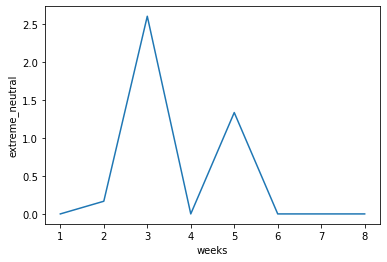

In [59]:
x_ticks = np.arange(start=1, stop=weekly_data.shape[0]+1, step=1).tolist()
print(x_ticks)
fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.plot(x_ticks, weekly_data['extreme_neutral'])  # Plot some data on the axes.
plt.xticks(np.arange(start=1, stop=weekly_data.shape[0]+1, step=1))
ax.set_xlabel('weeks')  # Add an x-label to the axes.
ax.set_ylabel('extreme_neutral')  # Add an x-label to the axes.

In [86]:
sql = """SELECT 
	a.id,
	a.name, 
	a.screen_name,
	count(t.id) as tweet_count
FROM tweets t INNER JOIN tweet_theories tt ON t.id = tt.tweet_id
INNER JOIN accounts a ON t.author_id = a.id
WHERE t.compound NOT BETWEEN -0.5 AND 0.5 AND tt.theory_id = %s
GROUP BY a.name, a.screen_name, a.id
ORDER BY tweet_count DESC
LIMIT 10;"""
theory_id = 14
top_acc_data = pd.read_sql_query(sql, cnx, params=(theory_id,))

In [87]:
top_acc_data.head(10)

,id,name,screen_name,tweet_count
0,800393642921771009,SciFiNovelHPS,SciFiNovelHPS,12
1,97650874,Sara Jones,SaraBoschiJones,1
2,187049457,✨Mandy 💫,TutsNY,1
3,324507238,🔥Red Ace 2020🔥 (K) ✝️🙏,RedAce66517,1
4,484272053,K,Kleer2go,1
5,1066477260,ΛNGΞL DΞ PΛΖ,Inevitable1111,1
6,987780156843585536,Roaring Brain,BrainRoaring,1
7,996970500009091072,DeeDrea,DeeDreaHamilton,1
8,1185860681335074818,snackkotone2020,odeco5goddess,1
9,1205512980126949376,Olimpia⭐️⭐️⭐️TEXT TRUMP TO 88022,MihaEll88540372,1


In [110]:
sql = """SELECT 
	CONCAT('#',h.value) AS hashtag,
	h.id AS hashtag_id,
	count(t.id) as hashtag_count
FROM tweets t INNER JOIN tweet_theories tt ON t.id = tt.tweet_id
INNER JOIN tweet_hashtags th ON t.id = th.tweet_id
INNER JOIN hashtags h ON th.hashtag_id = h.id
WHERE t.compound NOT BETWEEN -0.5 AND 0.5 AND tt.theory_id = %s
GROUP BY h.value, h.id
ORDER BY hashtag_count DESC
LIMIT 10;"""
theory_id = 12
top_hash_data = pd.read_sql_query(sql, cnx, params=(theory_id,))

In [111]:
top_hash_data.head(10)

,hashtag,hashtag_id,hashtag_count
0,#FlatEarth,4209470,47
1,#QAnon,20506,27
2,#flatearth,3436024,23
3,#coronavirus,12,21
4,#NoVaccines,28270,15
5,#ConspiracyTheory,319318,15
6,#Vaxxed,20002,15
7,#Woke,2045897,15
8,#QArmy,162788,14
9,#qanon,25091,12
